# Line of Sight Calculations

For particle `Galaxies` its possible to compute line of sight column densities from the particle distribtions. These line of sight calculations will compute the line of sight column density for one particle component based on another. In this example we will show how to compute the column density of the gas component from the perspective of the star particles.

Before demonstrating this we need to generate a galaxy to demonstrate with.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import cKDTree
from unyt import Myr, Msun, Mpc, yr

from synthesizer.kernel_functions import Kernel
from synthesizer.parametric import SFH, ZDist
from synthesizer.parametric import Stars as ParametricStars
from synthesizer.particle import BlackHoles, Galaxy
from synthesizer.particle.gas import Gas
from synthesizer.particle.particles import CoordinateGenerator
from synthesizer.particle.stars import sample_sfhz


def calculate_smoothing_lengths(positions, num_neighbors=56):
    """Calculate the SPH smoothing lengths for a set of coordinates."""
    tree = cKDTree(positions)
    distances, _ = tree.query(positions, k=num_neighbors + 1)

    # The k-th nearest neighbor distance (k = num_neighbors)
    kth_distances = distances[:, num_neighbors]

    # Set the smoothing length to the k-th nearest neighbor
    # distance divided by 2.0
    smoothing_lengths = kth_distances / 2.0

    return smoothing_lengths


# Define the grid (normally this would be defined by an SPS grid)
log10ages = np.arange(6.0, 10.5, 0.1)
metallicities = 10 ** np.arange(-5.0, -1.5, 0.1)
Z_p = {"metallicity": 0.01}
metal_dist = ZDist.DeltaConstant(**Z_p)
sfh_p = {"max_age": 100 * Myr}
sfh = SFH.Constant(**sfh_p)  # constant star formation


# Generate the star formation metallicity history
mass = 10**10
param_stars = ParametricStars(
    log10ages,
    metallicities,
    sf_hist=sfh,
    metal_dist=metal_dist,
    initial_mass=mass * Msun,
)

# Define the number of particles
nstars = 1000
ngas = 10000

# Generate some random coordinates
coords = CoordinateGenerator.generate_3D_gaussian(nstars) * Mpc

# Calculate the smoothing lengths
smls = calculate_smoothing_lengths(coords) * Mpc

# Sample the parametric SFZH, producing a particle Stars object
# we will also pass some keyword arguments for some example attributes
part_stars = sample_sfhz(
    sfzh=param_stars.sfzh,
    log10ages=param_stars.log10ages,
    log10metallicities=param_stars.log10metallicities,
    coordinates=coords,
    smoothing_lengths=smls,
    nstar=nstars,
    current_masses=np.full(nstars, 10**8.7 / nstars) * Msun,
    redshift=1,
)

# Make fake properties
n = 4
masses = 10 ** np.random.uniform(low=7, high=9, size=n) * Msun
coordinates = np.random.normal(0, 1.5, (n, 3)) * Mpc
accretion_rates = 10 ** np.random.uniform(
    low=-2, high=1, size=n
)  * Msun / yr
metallicities = np.full(n, 0.01)

# And get the black holes object
blackholes = BlackHoles(
    masses=masses,
    coordinates=coordinates,
    accretion_rates=accretion_rates,
    metallicities=metallicities,
)

# Generate some random coordinates
coords = CoordinateGenerator.generate_3D_gaussian(ngas) * Mpc

# Calculate the smoothing lengths
smls = calculate_smoothing_lengths(coords) * Mpc

gas = Gas(
    masses=np.random.uniform(10**6, 10**6.5, ngas) * Msun,
    metallicities=np.random.uniform(0.01, 0.05, ngas),
    coordinates=coords,
    smoothing_lengths=smls,
    dust_to_metal_ratio=0.2,
)

# And create the galaxy
galaxy = Galaxy(
    stars=part_stars,
    gas=gas,
    black_holes=blackholes,
    redshift=1,
)

kernel = Kernel().get_kernel()

/home/runner/work/synthesizer/synthesizer/src/synthesizer/particle/galaxy.py:123: RuntimeWarning: Star forming gas particle mask not provided, setting sf_gas_mass and sf_gas_metallicity to `None`
  self.calculate_integrated_gas_properties()


## Atrbitrary column densities

If we want the gas column density for the stellar component we can call `stars.get_los_column_density` with the gas component as the argument. This method requires a string giving the name of the attribute to use for the column density, here we'll use the gas ``"masses"``, and also requires an SPH kernel to describe the gas particles (defined in the ``synthesizer.kernel_functions`` module).

In [2]:
metal_col_density = galaxy.stars.get_los_column_density(
    galaxy.gas,
    "masses",
    kernel=kernel,
)

This will return an array of the column densities for each star particle. Note, that this does not attach the column density to the component or galaxy. Lets plot a histogram to see what we got.

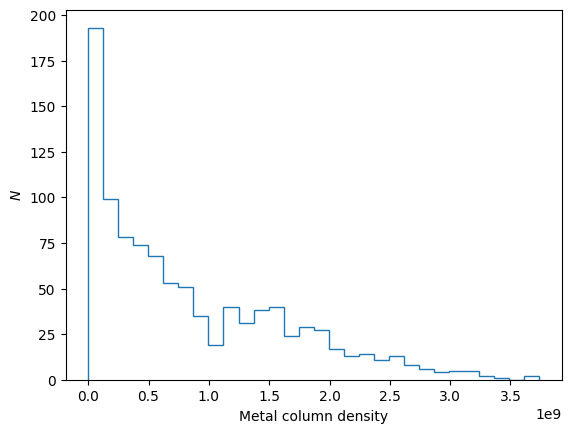

In [3]:
fig, ax = plt.subplots()
ax.hist(metal_col_density, bins=30, histtype="step")
ax.set_xlabel("Metal column density")
ax.set_ylabel("$N$")
plt.show()
plt.close(fig)

If instead we wanted the dust column density for the galaxies black holes we instead call `black_holes.get_los_column_density` with the gas component, ``"dust_masses"``, and the SPH kernel.

In [4]:
dust_bh_col_density = galaxy.black_holes.get_los_column_density(
    galaxy.gas,
    "dust_masses",
    kernel=kernel,
)
print(dust_bh_col_density)

[350761.78447117  10782.14271181  23666.82903494      0.        ]


## Line of sight optical depth

A special case of line of sight column density calculation is the calculation of line of sight optical depths (as described in (Vijayan+20)[https://ui.adsabs.harvard.edu/abs/2021MNRAS.501.3289V/abstract]). These compute the line of sight optical depth based on the dust column density along the line of sight of an emitting particle. 

A galaxy contains ``get_stellar_los_tau_v`` and ``get_black_hole_los_tau_v`` methods for these calculations for stellar and black hole optical depths respectively. Unlike the arbitrary column densities, these methods will attach the optical depth to the component under the ``tau_v`` attribute as well as returning the optical depths. These methods require the dust opacity (``kappa``) and an SPH kernel. Below we demonstrate how to compute the optical depth for both galaxy components.



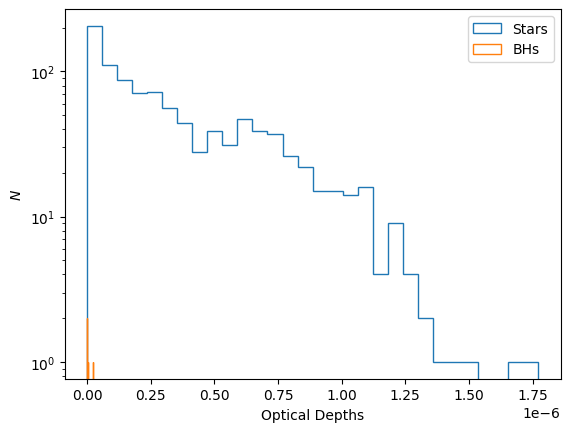

In [5]:
stellar_tau_v = galaxy.get_stellar_los_tau_v(
    kappa=0.07,
    kernel=kernel,
)
bh_tau_v = galaxy.get_black_hole_los_tau_v(
    kappa=0.07,
    kernel=kernel,
)

fig, ax = plt.subplots()
ax.hist(stellar_tau_v, bins=30, histtype="step", label="Stars")
ax.hist(bh_tau_v, bins=30, histtype="step", label="BHs")
ax.set_xlabel("Optical Depths")
ax.set_ylabel("$N$")
ax.set_yscale("log")
ax.legend()
plt.show()
plt.close(fig)